## Install dependencies

In [1]:
# !pip install matplotlib
# !pip install monai[all]
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install lightning
# !pip install nibabel
# !pip install scikit-image
# !pip install nilearn
# !pip install nibabel

## Imports

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt

from monai.inferers import sliding_window_inference
from monai.config import print_config


import torch
#import pytorch_lightning
import lightning
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from nilearn import plotting
import nibabel as nib
import numpy as np

from monai_unet import Net


2024-10-17 10:14:29.285229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 10:14:29.308539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 10:14:29.308561: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 10:14:29.324507: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device = ", device)
torch.backends.cudnn.benchmark = True

device =  cuda


In [4]:
PATH = "./Data/Task01_BrainTumour/"

## Run the training

In [5]:
torch.set_float32_matmul_precision('medium')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [6]:
# initialise the LightningModule
net = Net(device=device, datadir= PATH, in_channels=4, out_channels=4, augmentation=True)

# set up checkpoints
# TODO model callback set when val_loss lowest
checkpoint_callback = ModelCheckpoint(dirpath="./brain_data_lightning_models/", filename='{epoch}-{val_loss:.2f}-{val_dice:.2f}', monitor="val_dice", mode="max")
early_stopping_callback = EarlyStopping(monitor="val_loss", mode="min", patience=10, min_delta=0.1)
max_epochs = 100

# initialise Lightning's trainer.
trainer = lightning.Trainer(
    devices=[0],
    max_epochs=max_epochs,
    callbacks=[checkpoint_callback, early_stopping_callback],
    #callbacks=[checkpoint_callback],
    log_every_n_steps=4,
)

# train
trainer.fit(net)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
Loading dataset: 100%|██████████| 49/49 [00:52<00:00,  1.07s/it]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/datamining/brain_data_lightning_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | _model        | UNet       | 76.9 M | train
1 | loss_function | DiceCELoss | 0      | train
-----------------------------------------------------
76.9 M    Trainable params
0         Non-trainable params
76.9 M    Total params
307.510   Total estimated mod

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:05<00:00,  0.36it/s]current epoch: 0 current val_loss: 2.49556827545166 current mean dice: 0.0266
best mean dice: 0.0266 at epoch: 0
Epoch 0: 100%|██████████| 774/774 [02:59<00:00,  4.30it/s, v_num=12]       
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:03<00:00, 14.52it/s]current epoch: 0 current val_loss: 0.7641775608062744 current mean dice: 0.2353
best mean dice: 0.2353 at epoch: 0

Epoch 1: 100%|██████████| 774/774 [02:16<00:00,  5.66it/s, v_num=12]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:03<00:00, 15.54it/s]current epoch: 1 current val_loss: 0.6489234566688538 current mean dice: 0.3294
best mean dice: 0.3294 at epoch: 1

Epoch 2: 100%|██████████| 774/774 [02:21<00:00,  5.47it/s, v_num=12]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 48/48 [00:03<00:00, 13.82it/s]curr

## Plot the loss and dice metric

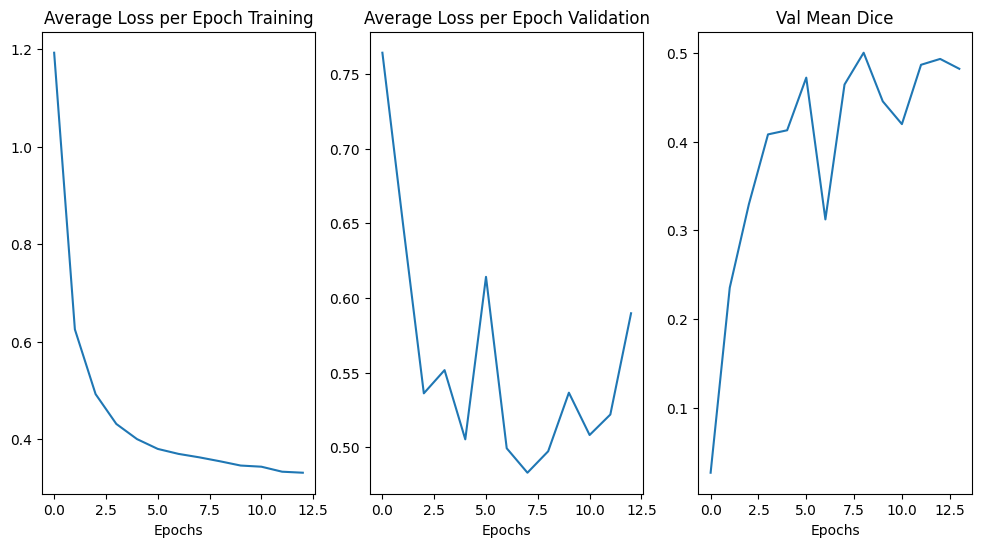

In [7]:
plt.figure("train", (12, 6))
plt.subplot(1, 3, 1)
plt.title("Average Loss per Epoch Training")
x = [i for i in range(0,len(net.epoch_train_loss))]
y = net.epoch_train_loss
plt.xlabel("Epochs")
plt.plot(x, y)
plt.subplot(1, 3, 2)
plt.title("Average Loss per Epoch Validation")
# skip first epoch for validation loss as it is very high
x = [i for i in range(0,len(net.epoch_val_loss)-1)]
y = net.epoch_val_loss[1:]
plt.xlabel("Epochs")
plt.plot(x, y)
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice")
x = [i for i in range(0,len(net.metric_values))]
y = net.metric_values
plt.xlabel("Epochs")
plt.plot(x, y)
plt.show()

## Test model on unseen data

In [8]:
# this will print the avg loss and dice metric on the test set
trainer.test()

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Loading dataset: 100%|██████████| 49/49 [01:04<00:00,  1.32s/it]
Restoring states from the checkpoint path at /home/datamining/brain_data_lightning_models/epoch=7-val_loss=0.48-val_dice=0.50.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/datamining/brain_data_lightning_models/epoch=7-val_loss=0.48-val_dice=0.50.ckpt


Testing DataLoader 0: 100%|██████████| 49/49 [00:04<00:00, 10.77it/s]


[{}]

## Load model from checkpoint to plot predictions

In [9]:
model = Net.load_from_checkpoint(checkpoint_callback.best_model_path, device = device, in_channels=4, out_channels=4, augmentation=False, datadir = PATH)
model.eval()
model.to(device)
model.prepare_data()

Loading dataset: 100%|██████████| 49/49 [01:04<00:00,  1.33s/it]


In [10]:
# make predictions
images = []
outputs = []
labels = []

test_loader = model.test_dataloader()

# predict for 10 images only
i = 0
for test_data in test_loader: 
    if i ==10:
        break
    test_inputs, test_labels = (
        test_data["image"].to(device),
        test_data["label"].to(device),
    )
    images.append(test_inputs)
    outputs.append(model.forward(test_inputs))
    labels.append(test_labels)
    i += 1

In [44]:
def plot_predictions(idx_of_image, outputs, images, labels, slice_end = None, step = 5, slice_start = 0):
    # Assuming outputs, labels, and images are your variables
    output = outputs[idx_of_image]
    label = labels[idx_of_image][0][0]
    image = images[idx_of_image][0][0]

    if slice_end == None:
        slice_end = output.shape[4]

    # Calculate the number of slices
    num_slices = int((slice_end - slice_start) / step)

    # Create a subplot with 'num_slices' rows and 3 columns
    plt.figure(figsize=(15, 5 * num_slices))

    for i in range(num_slices):
        # Increment the slice index
        current_slice = slice_start + i*step

        # Plot the Model Output
        plt.subplot(num_slices, 3, 3 * i + 1)
        with torch.no_grad():
            plt.imshow(torch.argmax(output.cpu(), dim=1)[0, :, :, current_slice])
        plt.title(f'Model Output - Slice {current_slice}')

        # Plot the Label
        plt.subplot(num_slices, 3, 3 * i + 2)
        plt.imshow(label.cpu()[:, :, current_slice])
        plt.title(f'Label - Slice {current_slice}')

        # Plot the Input Image
        plt.subplot(num_slices, 3, 3 * i + 3)
        plt.imshow(image.cpu()[:, :, current_slice])
        plt.title(f'Input Image - Slice {current_slice}')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plots
    plt.show()

## Plot predictions

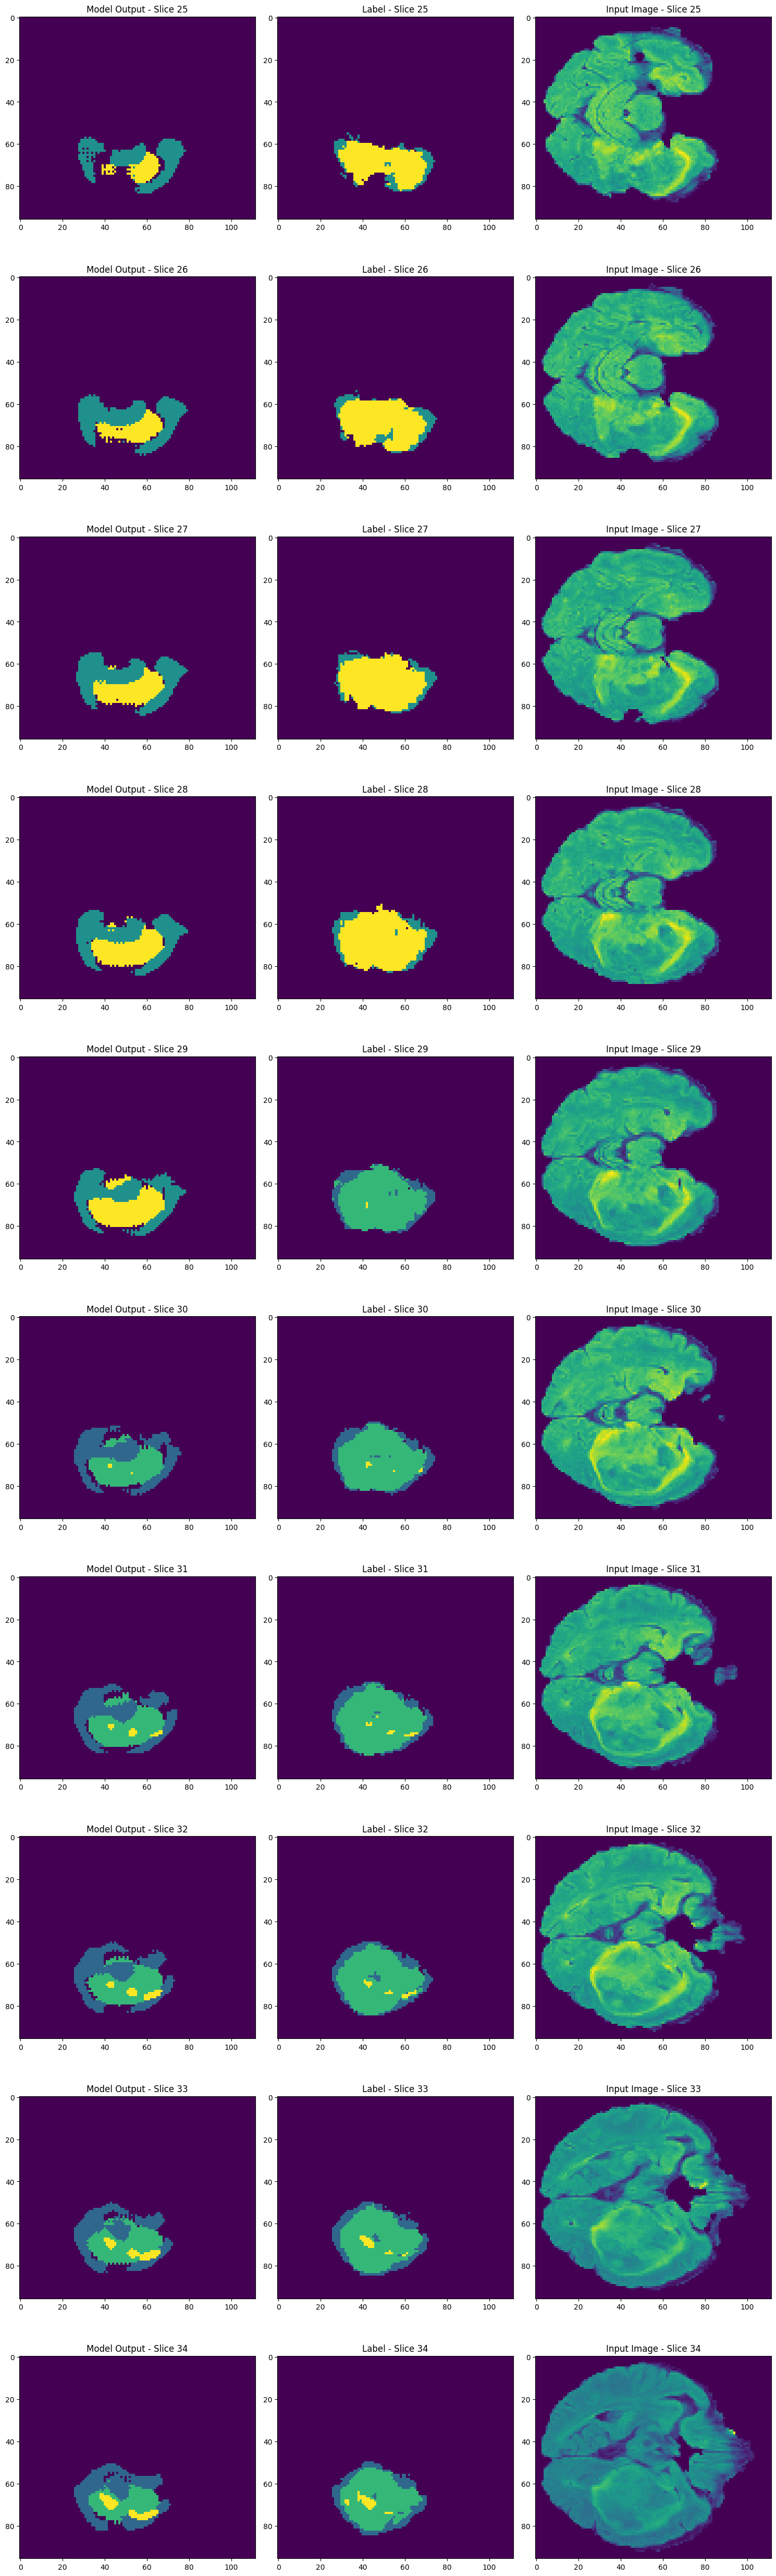

In [45]:
plot_predictions(9, outputs, images, labels, slice_end = 35, step = 1, slice_start = 25)

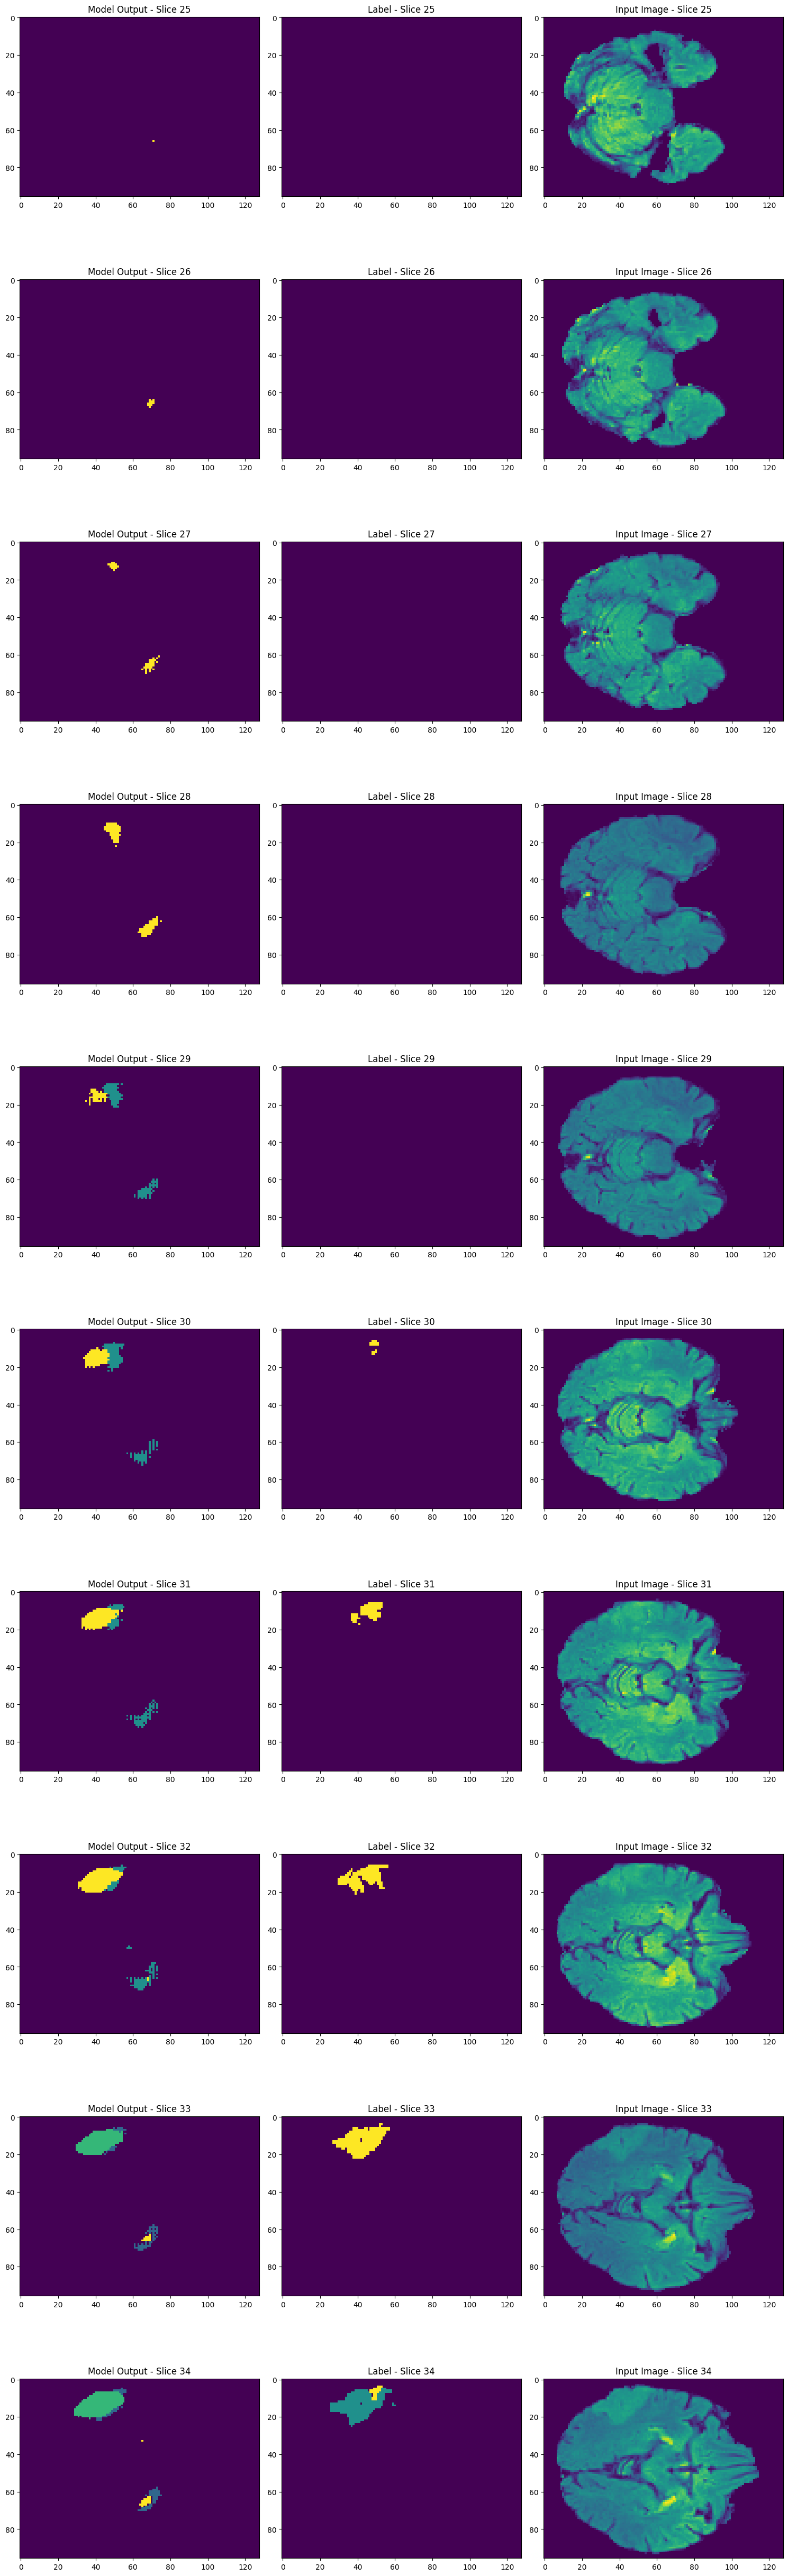

In [46]:
plot_predictions(6, outputs, images, labels, slice_end = 35, step = 1, slice_start = 25)

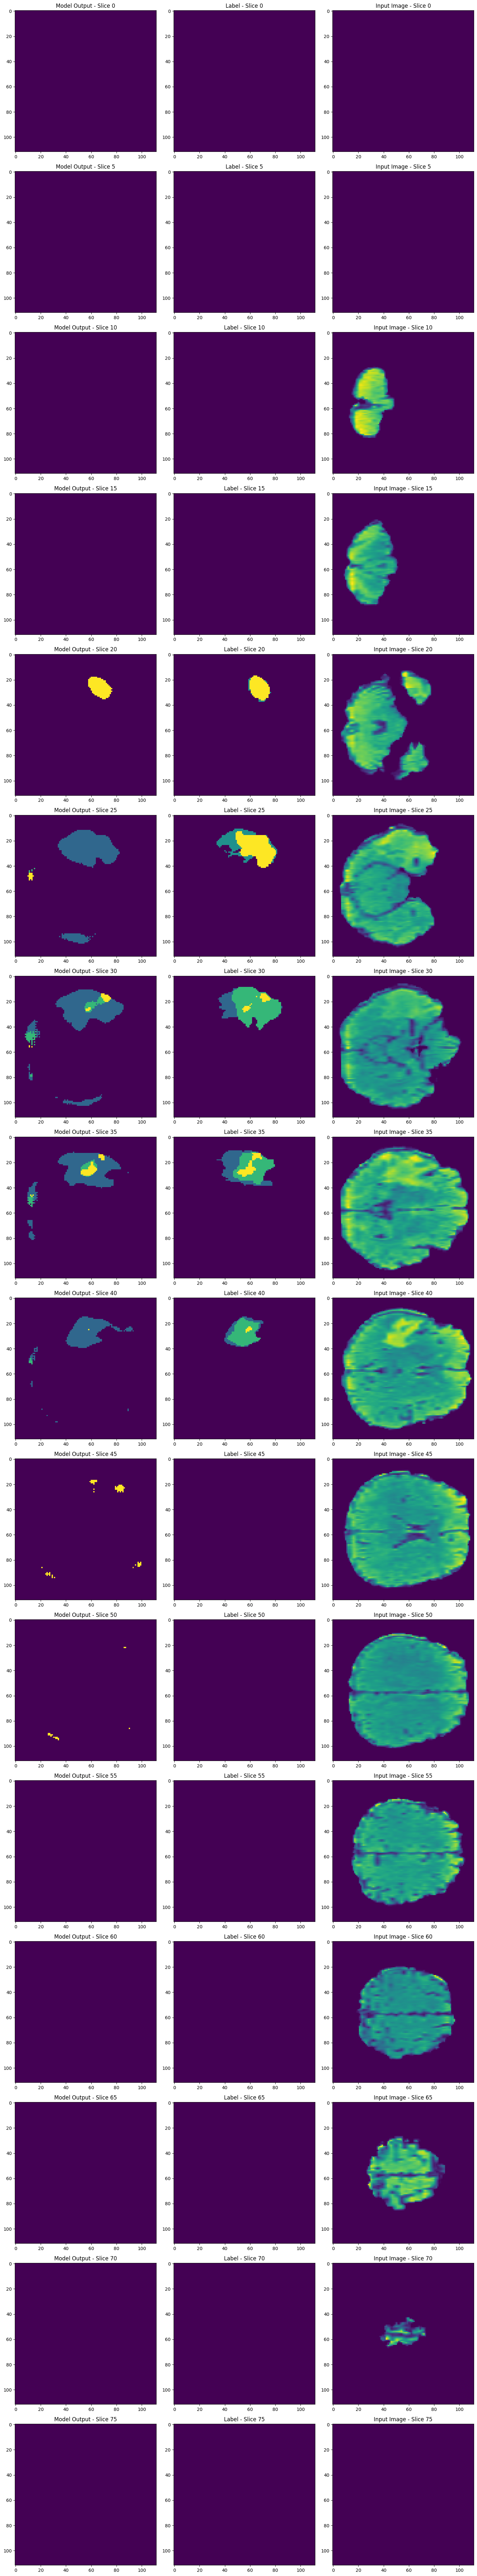

In [47]:
plot_predictions(0, outputs, images, labels)

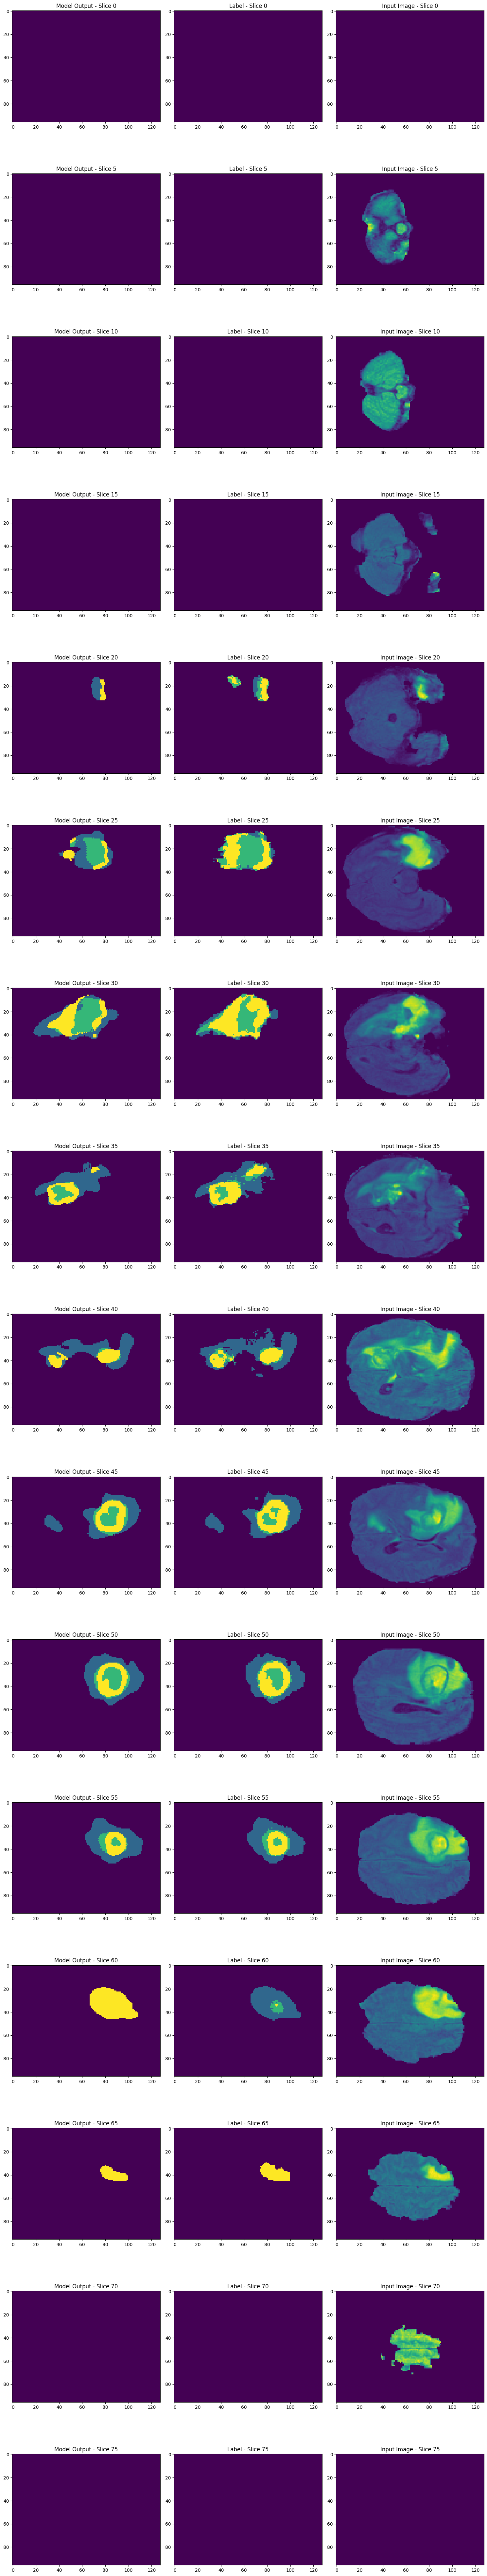

In [52]:
plot_predictions(3, outputs, images, labels)

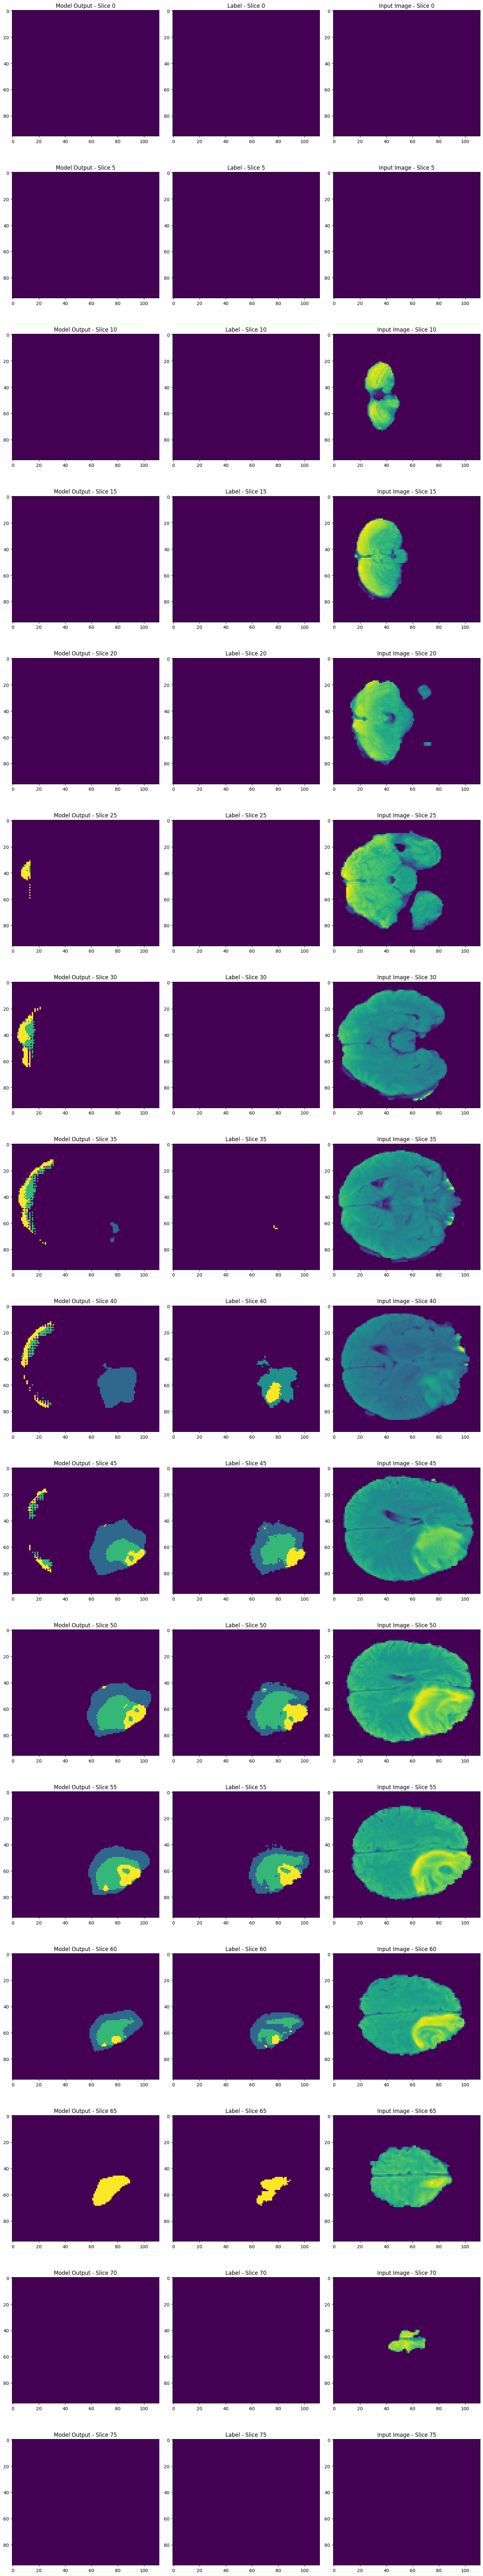

In [53]:
plot_predictions(5, outputs, images, labels)

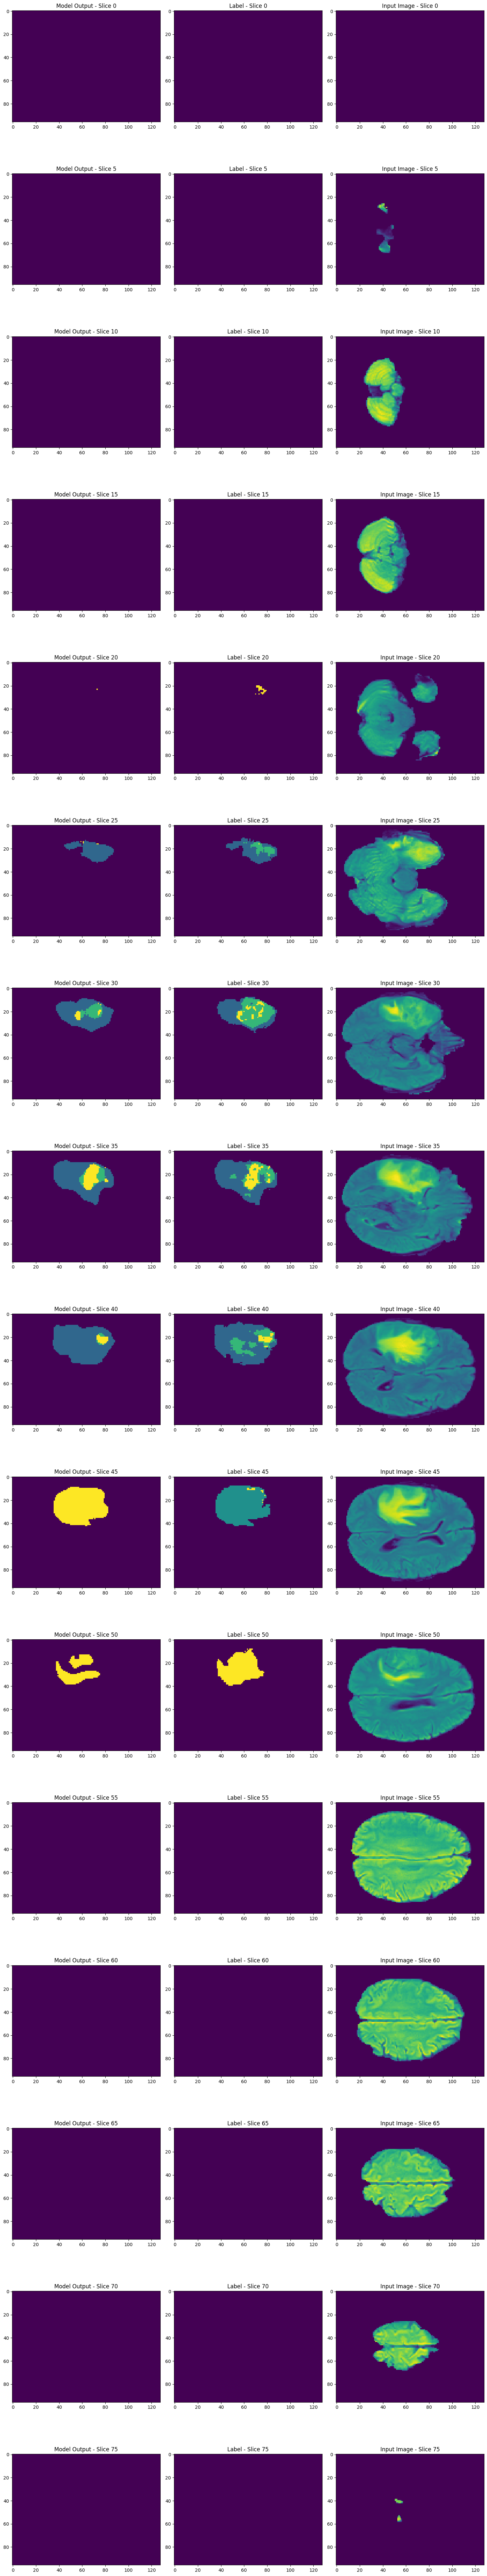

In [50]:
plot_predictions(8, outputs, images, labels)

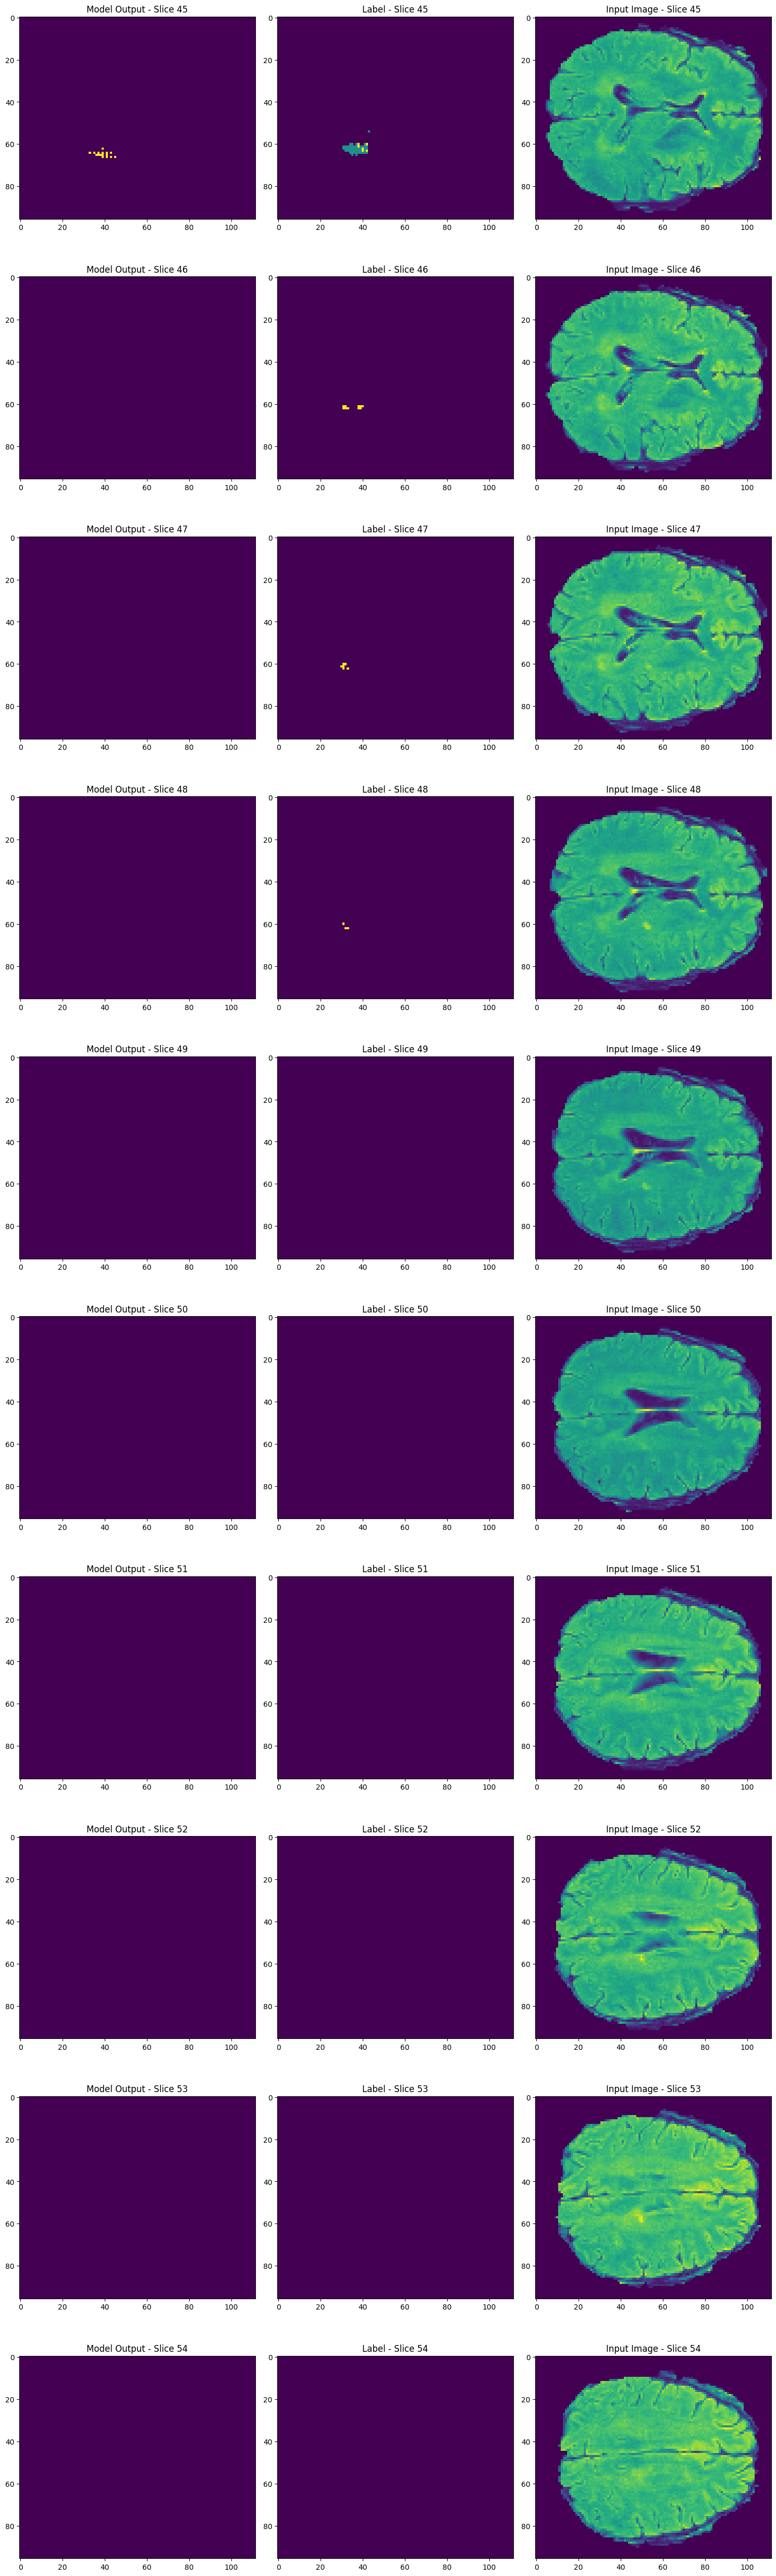

In [51]:
plot_predictions(9, outputs, images, labels, slice_end = 55, step = 1, slice_start = 45)